In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import numpy as np

In [2]:
df = pd.read_csv('Dataset_Ads.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              10000 non-null  int64  
 1   Gender           10000 non-null  object 
 2   Income           10000 non-null  float64
 3   Location         10000 non-null  object 
 4   Ad Type          10000 non-null  object 
 5   Ad Topic         10000 non-null  object 
 6   Ad Placement     10000 non-null  object 
 7   Clicks           10000 non-null  int64  
 8   Click Time       10000 non-null  object 
 9   Conversion Rate  10000 non-null  float64
 10  CTR              10000 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 859.5+ KB
None


In [26]:
np.random.seed(1)
n = 10000
# Adding Bid column
df['Conversion'] = (np.random.rand(n) < df['Conversion Rate']).astype(int)
df['Reward'] = df['Clicks'] + 3 * df['Conversion']

In [27]:
df['Bid'] = np.random.uniform(0.1, 5.0, size=n)

### Preprocessing Data

In [28]:
# Encoding categorical variables
label_encoders = {}
for col in ['Gender', 'Location', 'Ad Type', 'Ad Topic', 'Ad Placement']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scale numerical features
scaler = MinMaxScaler()
df[['Age', 'Income', 'CTR', 'Conversion Rate', 'Bid']] = scaler.fit_transform(df[['Age', 'Income', 'CTR', 'Conversion Rate', 'Bid']])

### Define the Q-Learning Environment

In [29]:
# Define state and action spaces
state_features = ['Age', 'Gender', 'Income', 'Location', 'Ad Type', 'Ad Topic', 'Ad Placement']
action_space = np.linspace(0.1, 5.0, 20)  # 10 bid levels
num_actions = len(action_space)

# Initialize Q-table
Q_table = {}

# Initialize Q-values randomly for all state-action pairs
def initialize_Q_table():
    for index, row in df.iterrows():
        state = tuple(row[state_features])
        if state not in Q_table:
            Q_table[state] = np.random.rand(num_actions)
initialize_Q_table()

### Define Helper Functions for Q-Learning

In [ ]:
action_column = 'Bid'
reward_column = 'Reward'

### Dictionary of historical action and rewards

In [ ]:
state_action_rewards = {}

# Helper function to round state features and action to 2 decimal places
def round_state(state):
    return tuple(round(feature, 2) for feature in state)
def round_action(action):
    return round(action, 2)

# Function to preprocess and update the state_action_rewards dictionary
def preprocess_rewards_with_ranges(df, state_features, action_column, reward_column):
    for index, row in df.iterrows():
        state = round_state(tuple(row[state_features]))
        action = round_action(row[action_column])
        reward = row[reward_column]
        
        if state not in state_action_rewards:
            state_action_rewards[state] = {}
        
        if action not in state_action_rewards[state]:
            state_action_rewards[state][action] = -float('inf')
        
        # Update the reward for the state-action pair
        state_action_rewards[state][action] = max(state_action_rewards[state][action], reward)


preprocess_rewards_with_ranges(df, state_features, action_column, reward_column)

### Train the Model

In [71]:
# Parameters
alpha = 0.2  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay = 0.999  # Epsilon decay factor
num_episodes = 500

# Function to get the reward for a given state and action from the pre-filled dictionary
def calculate_reward_with_ranges(state, action):
    rounded_state = round_state(state)
    rounded_action = round_action(action)
    if rounded_state in state_action_rewards and rounded_action in state_action_rewards[rounded_state]:
        return state_action_rewards[rounded_state][rounded_action]
    return 0

# Epsilon-greedy action selection
def get_action(state):
    if np.random.rand() < epsilon:
        return np.random.choice(range(num_actions))  # Explore
    return np.argmax(Q_table[state])  # Exploit

# Update the Q-table
def update_Q_table(state, action, reward, next_state):
    # Initialize Q-values for the state if it doesn't exist
    if state not in Q_table:
        Q_table[state] = np.zeros(num_actions)
    
    # Initialize Q-values for the next state if it doesn't exist
    if next_state not in Q_table:
        Q_table[next_state] = np.zeros(num_actions)
    
    # Q-learning update rule
    best_next_action = np.argmax(Q_table[next_state])
    target = reward + gamma * Q_table[next_state][best_next_action]
    Q_table[state][action] += alpha * (target - Q_table[state][action])

In [72]:
# TRAINING LOOP
reward = []
for episode in range(num_episodes):
    total_reward = 0
    for index, row in df.iterrows():
        state = round_state(tuple(row[state_features]))
        action_index = get_action(state)
        action = round_action(action_space[action_index])
        reward = calculate_reward_with_ranges(state, action)
        
        # Update Q-table
        next_state = round_state(tuple(row[state_features]))
        update_Q_table(state, action_index, reward, next_state)

        total_reward += reward
    rewards.append(total_reward)

    # Decay epsilon for exploration-exploitation trade-off
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    if episode % 50 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

# Display the rewards for all episodes after training
print("Training complete. Rewards by episode:", rewards)

Episode 0, Total Reward: 166
Episode 50, Total Reward: 238
Episode 100, Total Reward: 376
Episode 150, Total Reward: 470
Episode 200, Total Reward: 626
Episode 250, Total Reward: 724
Episode 300, Total Reward: 713
Episode 350, Total Reward: 790
Episode 400, Total Reward: 812
Episode 450, Total Reward: 993
Training complete. Rewards by episode: [-9964, -9991, -9956, -9937, -9988, -9975, -9963, -9991, -9973, -9977, -9970, -9956, -9875, -9876, -9863, -9845, -9834, -9874, -9824, -9860, -9816, -9828, -9867, -9873, -9858, -9802, -9785, -9822, -9859, -9837, -9812, -9776, -9871, -9785, -9814, -9820, -9796, -9839, -9863, -9817, -9784, -9857, -9788, -9772, -9814, -9775, -9741, -9822, -9810, -9692, -9799, -9782, -9757, -9801, -9662, -9818, -9737, -9765, -9669, -9814, -9727, -9784, -9824, -9685, -9670, -9719, -9739, -9751, -9741, -9841, -9818, -9808, -9863, -9823, -9876, -9803, -9866, -9804, -9818, -9912, -9849, -9808, -9842, -9826, -9783, -9854, -9833, -9797, -9790, -9800, -9813, -9797, -9790, -9

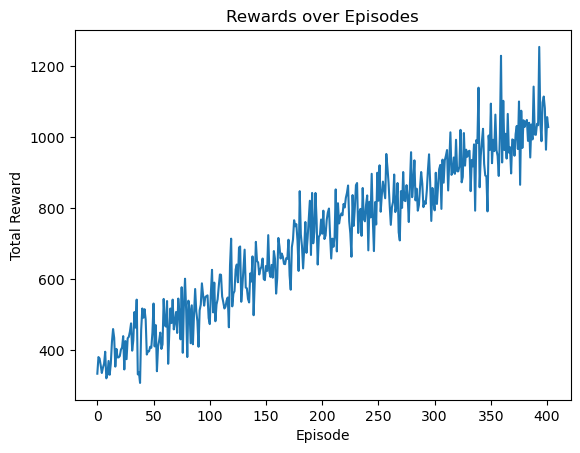

In [76]:
# Plotting the rewards over episodes
plt.plot(rewards[200:])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

### Evaluate the Model

In [77]:
# Evaluation
test_rewards = []
for index, row in df.iterrows():
    state = tuple(row[state_features])
    action_index = np.argmax(Q_table.get(state, np.zeros(num_actions)))
    action = action_space[action_index]
    
    # Calculate reward based on action taken
    reward = row['Reward']
    test_rewards.append(reward)

average_reward = np.mean(test_rewards)
print(f"Average Reward on Evaluation Data: {average_reward}")

Average Reward on Evaluation Data: 5.8427


### Result

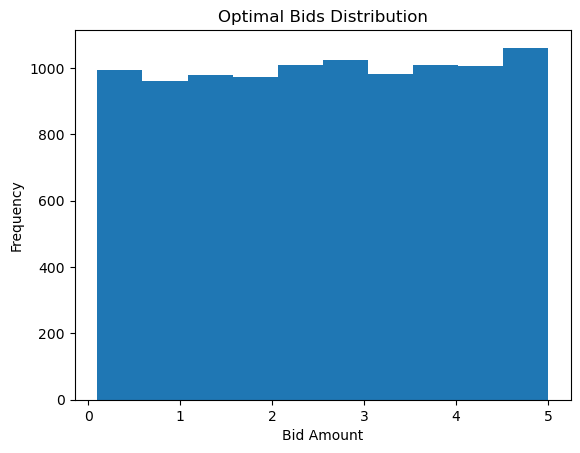

In [78]:
# Save Q-table for future use
import pickle
with open('Q_table.pkl', 'wb') as f:
    pickle.dump(Q_table, f)

# Visualizing optimal bid distribution
optimal_bids = [action_space[np.argmax(Q_table[tuple(row[state_features])])] for _, row in df.iterrows()]
plt.hist(optimal_bids, bins=10)
plt.xlabel('Bid Amount')
plt.ylabel('Frequency')
plt.title('Optimal Bids Distribution')
plt.show()